## Digital Filter Simulation Notebook

### Class DigitalFilter

In [1]:
import numpy as np
from scipy import signal


class DigitalFilter:
    def __init__(self, zeros=None, poles=None, gain=1) -> None:
        """
        Initialize the Filter class with zeros, poles, and gain.
        If zeros and poles are not given, they are set to an empty list.
        The default value for gain is 1.
        """
        self.__zeros = zeros if zeros else []
        self.__poles = poles if poles else []
        self.__all_pass = []
        self.__gain = gain

    # Define getters
    def get_zeros(self):
        return self.__zeros[:]

    def get_poles(self):
        return self.__poles[:]

    def get_gain(self):
        return self.__gain

    def get_all_pass(self):
        return self.__all_pass[:]

    # Define setters
    def set_zeros(self, zeros: list) -> None:
        """
        Set the zeros of the filter.
        """
        self.__zeros = [*self.__zeros, *zeros]

    def set_poles(self, poles: list) -> None:
        """
        Set the poles of the filter.
        """
        self.__poles = [*self.__poles, *poles]

    def set_gain(self, gain: float) -> None:
        """
        Set the gain of the filter.
        """
        self.__gain = gain

    # Define instance methods
    def response(self, w=None) -> tuple:
        """
        Get the response of the filter at a given frequency (w).
        If w is not given, compute the response at a range of frequencies.
        Returns a tuple of w (frequency), magnitude, and phase.
        """
        if w is None:
            w, response = signal.freqz_zpk(self.__zeros, self.__poles, self.__gain)
            # `w` is the x_axis from 0 hz to fmax hz (default value normalized from 0 to pi)
            # `response` is the complex output of z_transform where we can get the magnitude & phase
        else:
            response = signal.zpk_eval_response(self.__zeros, self.__poles, self.__gain, w)
        magnitude = 20 * np.log10(np.abs(response))
        # convert from hz into decibels
        phase = np.unwrap(np.angle(response))   # `np.unwrap` to remove phase discontinuities
        return w, magnitude, phase

    def add_all_pass(self, a: complex):
        """
        Add one all-pass filter with coefficient a to the filter.
        """
        self.__all_pass.append(a)
        self.__poles.append(a)
        self.__zeros.append(1 / np.conj(a))

    def add_list_all_pass(self, a_list: list):
        """
        Add one or more all-pass filters with coefficient a to the filter.
        """
        self.__all_pass = a_list.copy()
        self.__poles = [*self.__poles, *a_list]
        b_list = []
        for i in range(len(a_list)):
            b_list.append(1 / np.conj(a_list[i]))
        self.__zeros = [*self.__zeros, *b_list]

    def remove_zero(self, zero:complex):
        self.__zeros.remove(zero)

    def remove_pole(self, pole:complex):
        self.__poles.remove(pole)

    def remove_all_zeros(self):
        self.__zeros = []

    def remove_all_poles(self):
        self.__poles= []

    def remove_all_pass(self, a:complex):
        """
        Remove one all-pass filter with coefficient a to the filter.
        """
        self.__all_pass.remove(a)
        self.__poles.remove(a)
        self.__zeros.remove(1 / np.conj(a))

    def remove_all_all_passes(self):
        """
        Remove all all-pass filters from the filter.
        """
        self.__zeros = self.__zeros[0:len(self.__zeros) - len(self.__all_pass)]
        self.__poles = self.__poles[0:len(self.__poles) - len(self.__all_pass)]
        self.__all_pass = []

    def apply_filter(self, values: list) -> []:
        numerator , denominator = signal.zpk2tf(self.__zeros,self.__poles, self.__gain)
        filtered_signal = np.real(signal.lfilter(numerator, denominator, values))
        return filtered_signal

In [2]:
import matplotlib.pyplot as plt

# initialize object from class
filter_1 = DigitalFilter(zeros=[complex(0.3, 0.5), complex(0.6, -0.6)],
                         poles=[complex(0.1, 0.4), complex(0.2, -0.5)])

In [3]:
# initialize coordinates to draw unit circle zeros & poles
zeros_x = []
zeros_y = []
poles_x = []
poles_y = []

def update_zp_circle():
    for z in filter_1.get_zeros():
        zeros_x.append(z.real)
        zeros_y.append(z.imag)
    for p in filter_1.get_poles():
        poles_x.append(p.real)
        poles_y.append(p.imag)

update_zp_circle()

### Original Filter

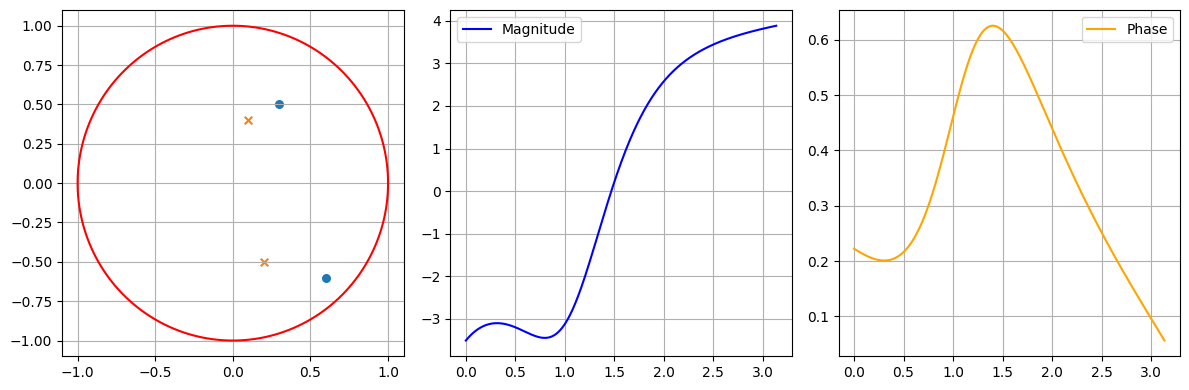

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

a = np.cos(np.linspace(0, 2 * np.pi, 200))
b = np.sin(np.linspace(0, 2 * np.pi, 200))

ax1.scatter(zeros_x, zeros_y, s=30, marker='o')
ax1.scatter(poles_x, poles_y, s=30, marker='x')
ax1.plot(a, b, color="red")
ax1.grid()

w, m, p = filter_1.response()
ax2.plot(w,m, label='Magnitude', c='b')
ax2.grid()
ax2.legend()

ax3.plot(w,p, label='Phase', c='orange')
ax3.grid()
ax3.legend()

fig.tight_layout()
plt.show()

### Cancellation of zeros with poles

In [5]:
filter_1.set_poles([complex(0.2, 0.1)])
filter_1.set_zeros([complex(0.2, 0.1)])
update_zp_circle()
filter_1.get_poles()

[(0.1+0.4j), (0.2-0.5j), (0.2+0.1j)]

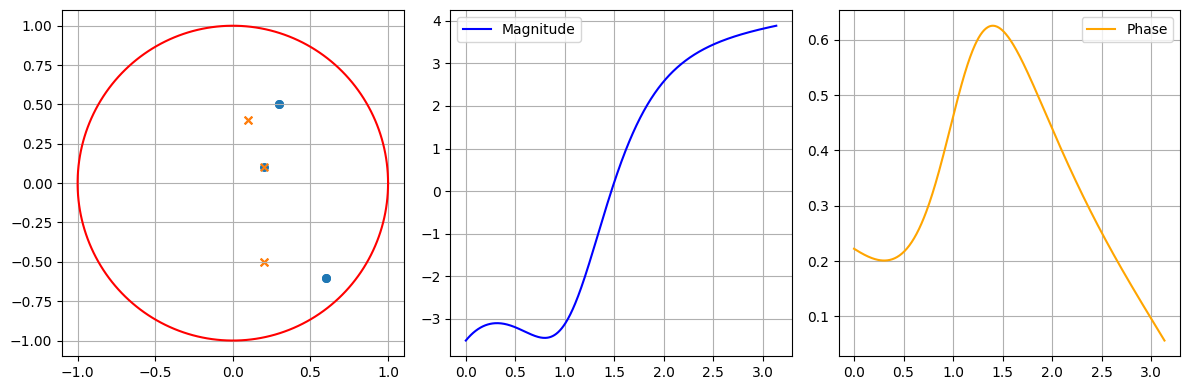

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

a = np.cos(np.linspace(0, 2 * np.pi, 200))
b = np.sin(np.linspace(0, 2 * np.pi, 200))
ax1.scatter(zeros_x, zeros_y, s=30, marker='o')
ax1.scatter(poles_x, poles_y, s=30, marker='x')
ax1.plot(a, b, color="red")
ax1.grid()

w, m, p = filter_1.response()
ax2.plot(w,m, label='Magnitude', c='b')
ax2.grid()
ax2.legend()

ax3.plot(w,p, label='Phase', c='orange')
ax3.grid()
ax3.legend()

fig.tight_layout()
plt.show()

### Add all pass filters

In [7]:
filter_1.add_list_all_pass([complex(0.2), complex(-0.1), complex(0.2,0.1)])
update_zp_circle()

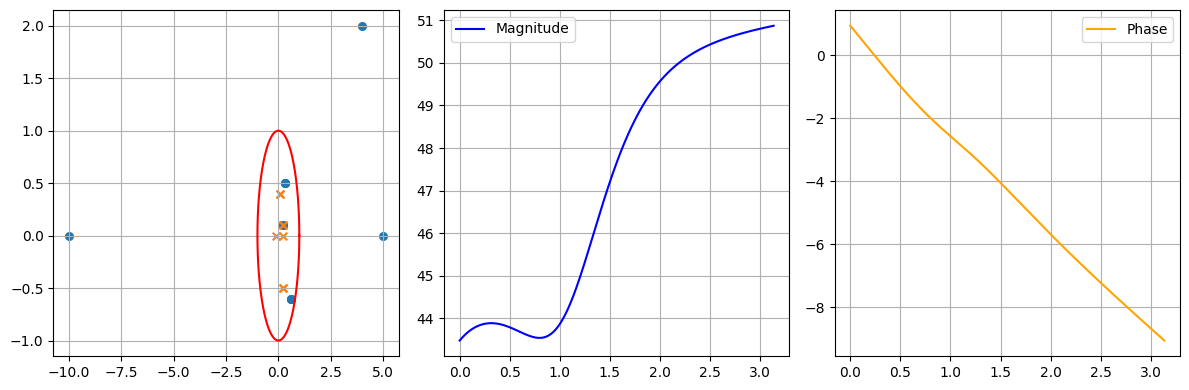

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

a = np.cos(np.linspace(0, 2 * np.pi, 200))
b = np.sin(np.linspace(0, 2 * np.pi, 200))
ax1.scatter(zeros_x, zeros_y, s=30, marker='o')
ax1.scatter(poles_x, poles_y, s=30, marker='x')
ax1.plot(a, b, color="red")
ax1.grid()

w, m, p = filter_1.response()
ax2.plot(w,m, label='Magnitude', c='b')
ax2.grid()
ax2.legend()

ax3.plot(w,p, label='Phase', c='orange')
ax3.grid()
ax3.legend()

fig.tight_layout()
plt.show()

In [9]:
print('Original Filter with all-pass data')
print('-'*100)
print(f'all pass filters: {filter_1.get_all_pass()}')
print('-'*100)
print(f'filter zeros: {filter_1.get_zeros()}')
print('-'*100)
print(f'filter poles: {filter_1.get_poles()}')
print('-'*100)

Original Filter with all-pass data
----------------------------------------------------------------------------------------------------
all pass filters: [(0.2+0j), (-0.1+0j), (0.2+0.1j)]
----------------------------------------------------------------------------------------------------
filter zeros: [(0.3+0.5j), (0.6-0.6j), (0.2+0.1j), (5+0j), (-10-0j), (4+2j)]
----------------------------------------------------------------------------------------------------
filter poles: [(0.1+0.4j), (0.2-0.5j), (0.2+0.1j), (0.2+0j), (-0.1+0j), (0.2+0.1j)]
----------------------------------------------------------------------------------------------------


In [10]:
filter_1.remove_all_pass(complex(0.2,0.1))

print('Original Filter with remove one all-pass data')
print('-'*100)
print(f'all pass filters: {filter_1.get_all_pass()}')
print('-'*100)
print(f'filter zeros: {filter_1.get_zeros()}')
print('-'*100)
print(f'filter poles: {filter_1.get_poles()}')
print('-'*100)

Original Filter with remove one all-pass data
----------------------------------------------------------------------------------------------------
all pass filters: [(0.2+0j), (-0.1+0j)]
----------------------------------------------------------------------------------------------------
filter zeros: [(0.3+0.5j), (0.6-0.6j), (0.2+0.1j), (5+0j), (-10-0j)]
----------------------------------------------------------------------------------------------------
filter poles: [(0.1+0.4j), (0.2-0.5j), (0.2+0j), (-0.1+0j), (0.2+0.1j)]
----------------------------------------------------------------------------------------------------


In [11]:
filter_1.remove_all_all_passes()

print('Original Filter with all all-passs data')
print('-'*100)
print(f'all pass filters: {filter_1.get_all_pass()}')
print('-'*100)
print(f'filter zeros: {filter_1.get_zeros()}')
print('-'*100)
print(f'filter poles: {filter_1.get_poles()}')
print('-'*100)

Original Filter with all all-passs data
----------------------------------------------------------------------------------------------------
all pass filters: []
----------------------------------------------------------------------------------------------------
filter zeros: [(0.3+0.5j), (0.6-0.6j), (0.2+0.1j)]
----------------------------------------------------------------------------------------------------
filter poles: [(0.1+0.4j), (0.2-0.5j), (0.2+0j)]
----------------------------------------------------------------------------------------------------


In [12]:
filter_1.remove_zero(complex(0.3,0.5))
filter_1.remove_pole(complex(0.1,0.4))

print('Original Filter with remove zero & pole data')
print('-'*100)
print(f'all pass filters: {filter_1.get_all_pass()}')
print('-'*100)
print(f'filter zeros: {filter_1.get_zeros()}')
print('-'*100)
print(f'filter poles: {filter_1.get_poles()}')
print('-'*100)

Original Filter with remove zero & pole data
----------------------------------------------------------------------------------------------------
all pass filters: []
----------------------------------------------------------------------------------------------------
filter zeros: [(0.6-0.6j), (0.2+0.1j)]
----------------------------------------------------------------------------------------------------
filter poles: [(0.2-0.5j), (0.2+0j)]
----------------------------------------------------------------------------------------------------


### Modified Filter

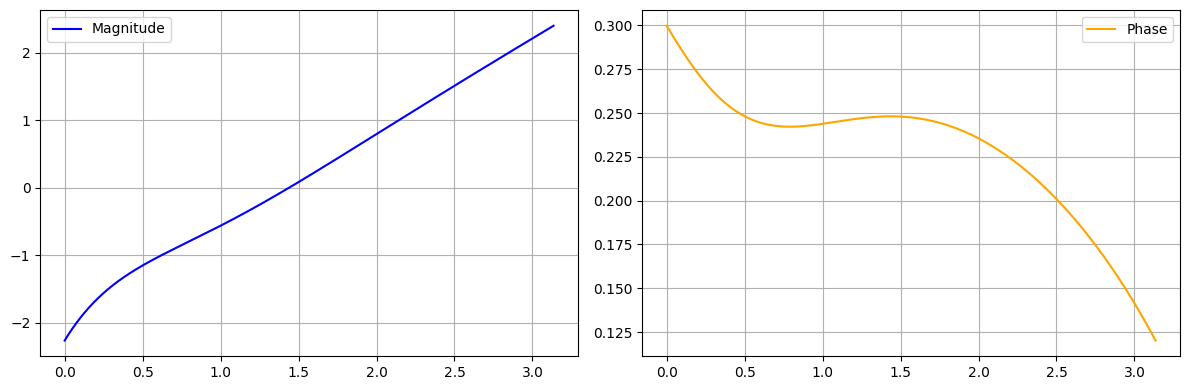

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

w, m, p = filter_1.response()
ax1.plot(w,m, label='Magnitude', c='b')
ax1.grid()
ax1.legend()

ax2.plot(w,p, label='Phase', c='orange')
ax2.grid()
ax2.legend()

fig.tight_layout()
plt.show()

### Apply digital filter on a signal

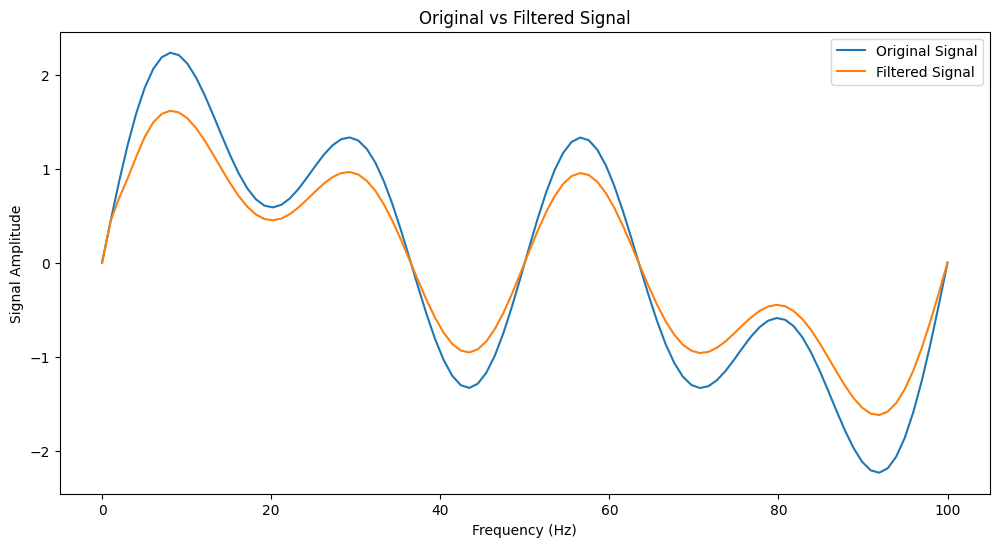

In [14]:
# Define the frequency range for the signal
f_range = np.linspace(0, 100, 100)

# Generate a signal with different frequencies
random_signal = np.sin(2 * np.pi * f_range) + np.sin(2 * np.pi * 2 * f_range) + np.sin(2 * np.pi * 4 * f_range)
filtered_signal = filter_1.apply_filter(random_signal)

# Plot the original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(f_range, random_signal, label='Original Signal')
plt.plot(f_range, filtered_signal, label='Filtered Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Signal Amplitude')
plt.title('Original vs Filtered Signal')
plt.legend()
plt.show()